## imports and stuff

/home/ubuntu/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


0015ceb851d7251b8f399e39779d1e7d
0030a160d58723ff36d73f41b170ec21
003f41c78e6acfa92430a057ac0b306e
006b96310a37b36cccb2ab48d10b49a3
008464bb8521d09a42985dd8add3d0d2
0092c13f9e00a3717fdc940641f00015
00986bebc45e12038ef0ce3e9962b51a
00cba091fa4ad62cc3200a657aeb957e
00edff4f51a893d80dae2d42a7f45ad1
0121c2845f2b7df060945b072b2515d7
013395589c01aa01f8df81d80fb0e2b8
01de8323fa065a8963533c4a86f2f6c1
01e349d34c06410e1da273add27be25c
01f1140c8e951e2a921b61c9a7e782c2
024efb7a1e67dc820eb61cbdaa090166
0257df465d9e4150adef13303433ff1e
026470d51482c93efc18b9803159c960
0268f3a7a17412178cfb039e71799a80
026be5d5e652b6a7488669d884ebe297
02801e3bbcc6966cb115a962012c35df
028996723faa7840bb57f57e28275e4c
031b7ec4fe96a3b035a8196264a8c8c3
0334c8242ce7ee1a6c1263096e4cc535
03bd22ed5858039af223c04993e9eb22
03fb0d0fdb187ee1160f09386b28c3f2
03ff23e445787886f8b0cb192b3c154d
043ed6cb6054cc13804a3dca342fa4d0
0482c444ac838adc5aa00d1064c976c1
04a3187ec2ed4198a25033071897bffc
04a52f49cdbfb8b99789b9e93f1ad319
04a8c47583

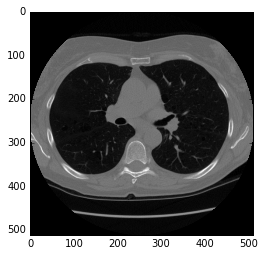

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/datadrive/kaggle_ds_bowl_17/stage1"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
lung = dicom.read_file('/datadrive/kaggle_ds_bowl_17/stage1/00cba091fa4ad62cc3200a657aeb957e/38c4ff5d36b5a6b6dc025435d62a143d.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

## Functions

In [3]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [4]:
ct_scan = read_ct_scan('/datadrive/kaggle_ds_bowl_17/stage1/00cba091fa4ad62cc3200a657aeb957e/') 

In [5]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [6]:
ct_scan.shape

(134, 512, 512)

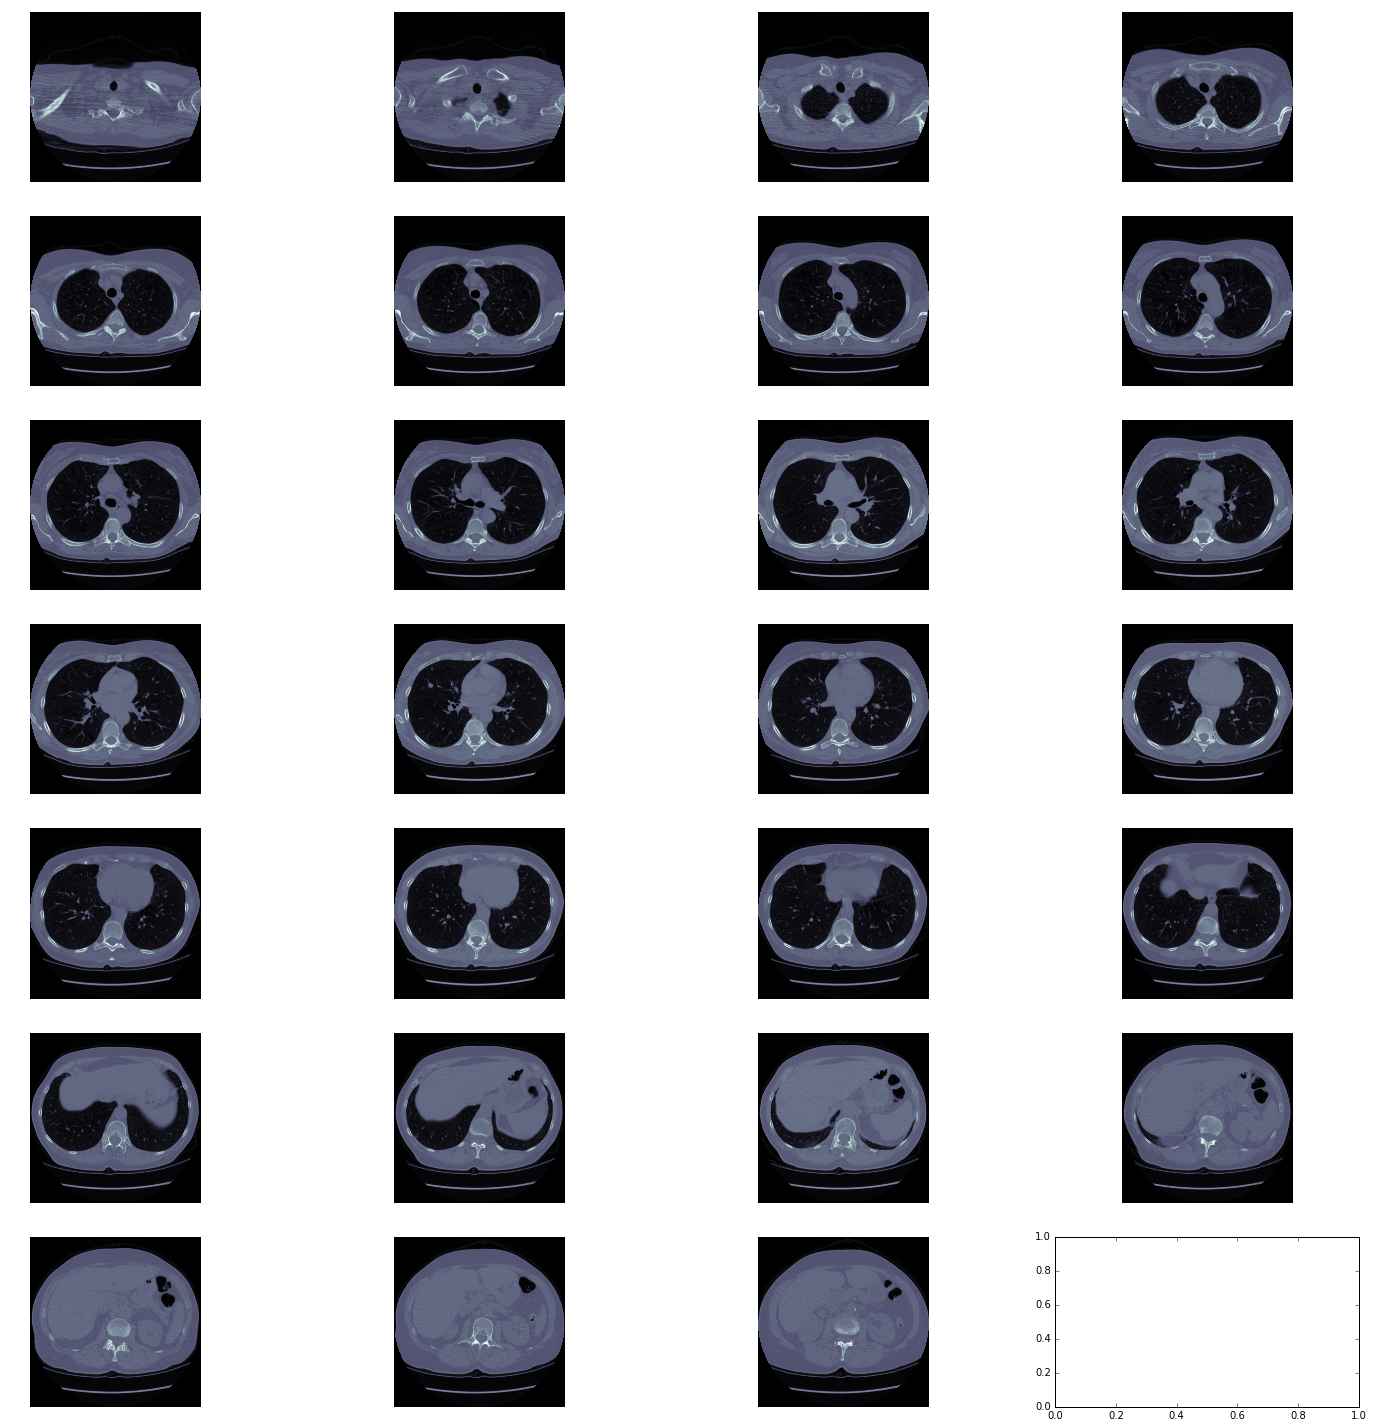

In [7]:
plot_ct_scan(ct_scan)

In [8]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [10]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

## processing and drawing

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

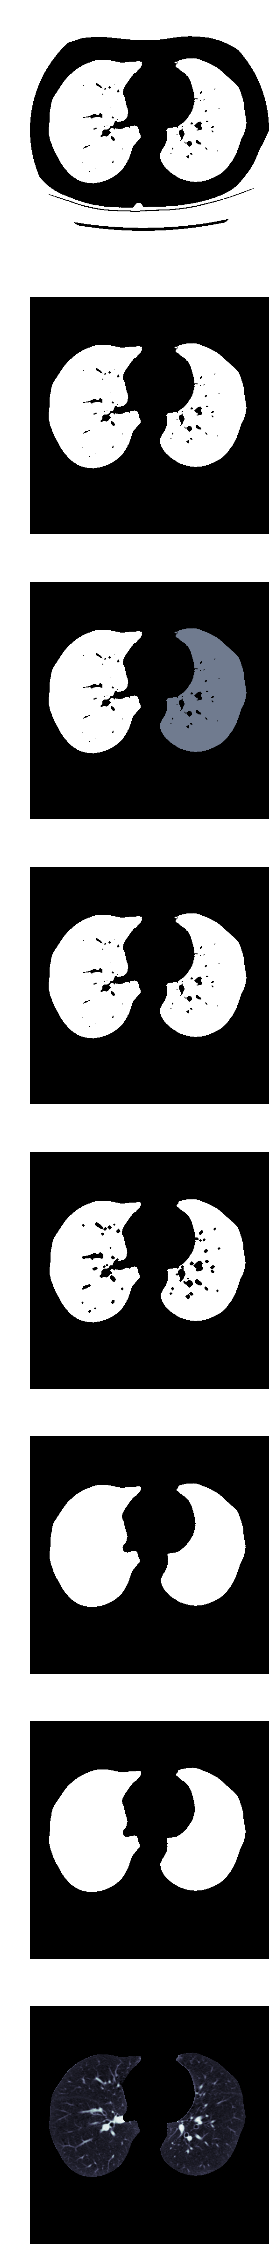

In [9]:
get_segmented_lungs(ct_scan[71], True)

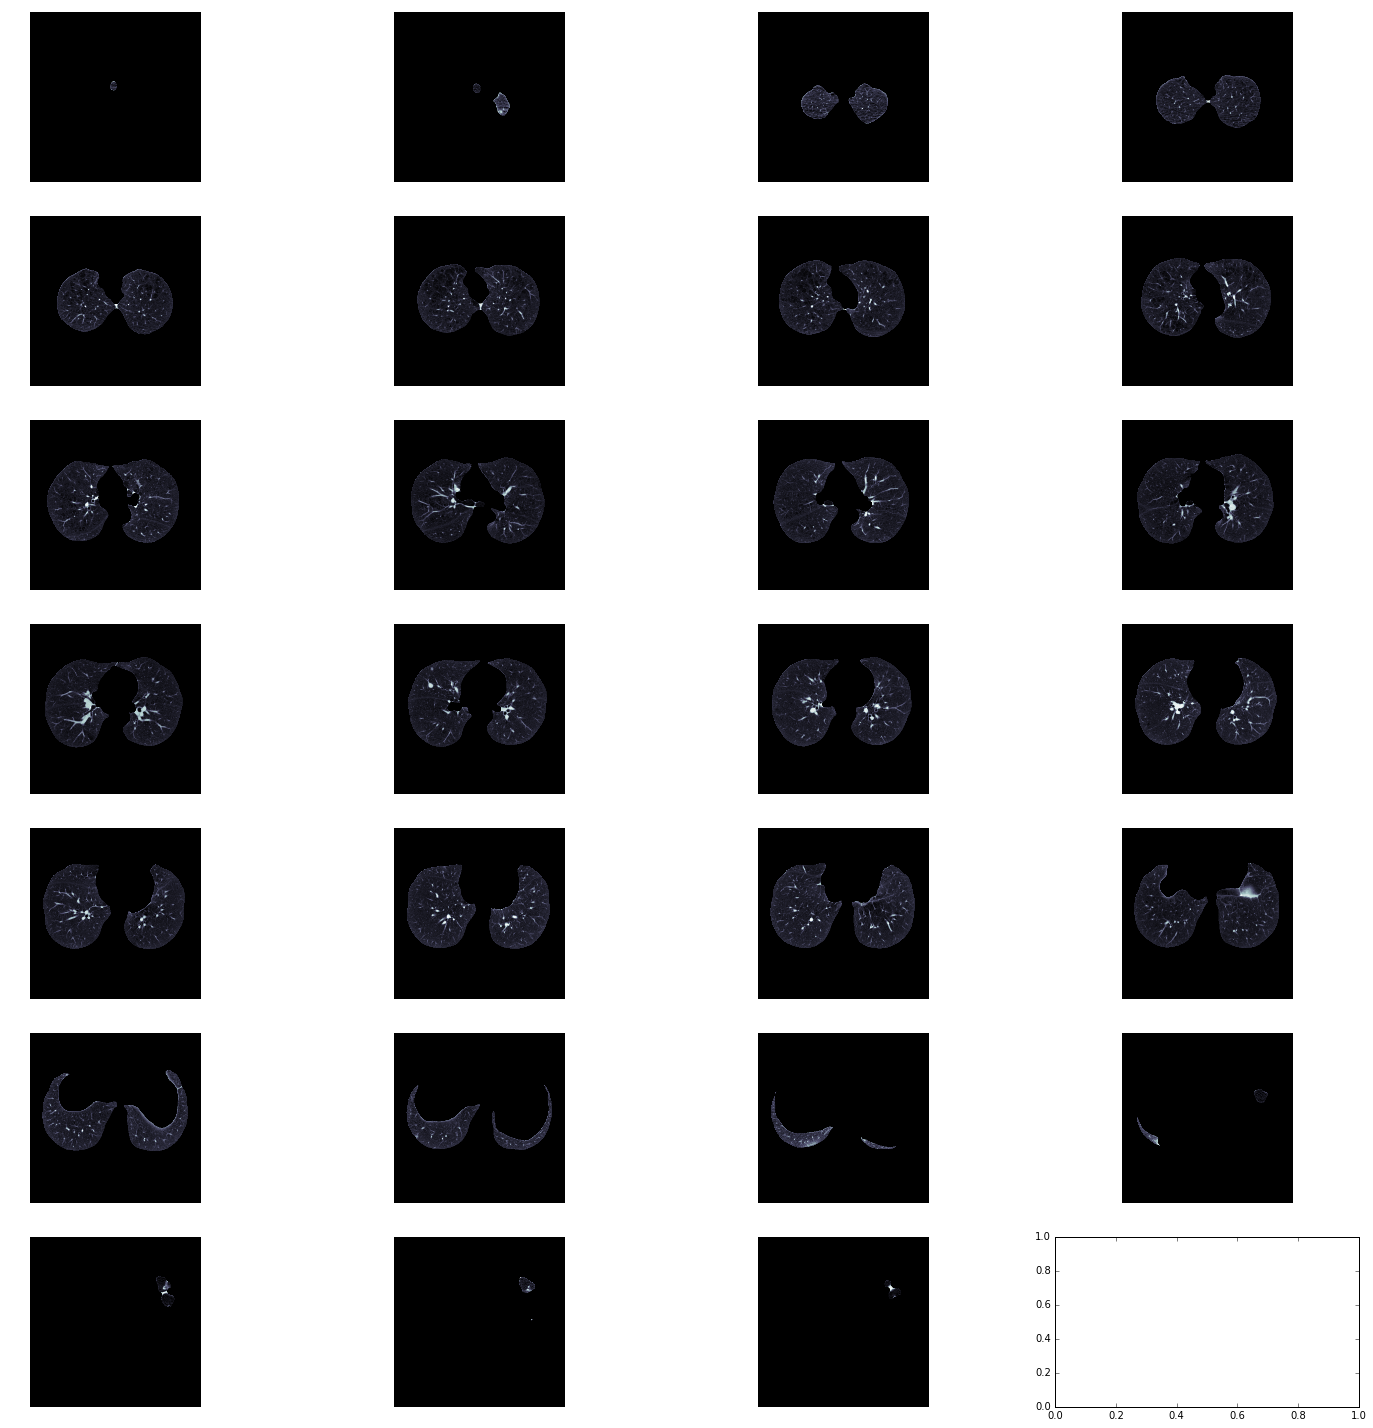

In [11]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules. It was found in experiments that all the region of interests have intensity > 604(-400 HU). So, we used to this threshold to filter the regions.

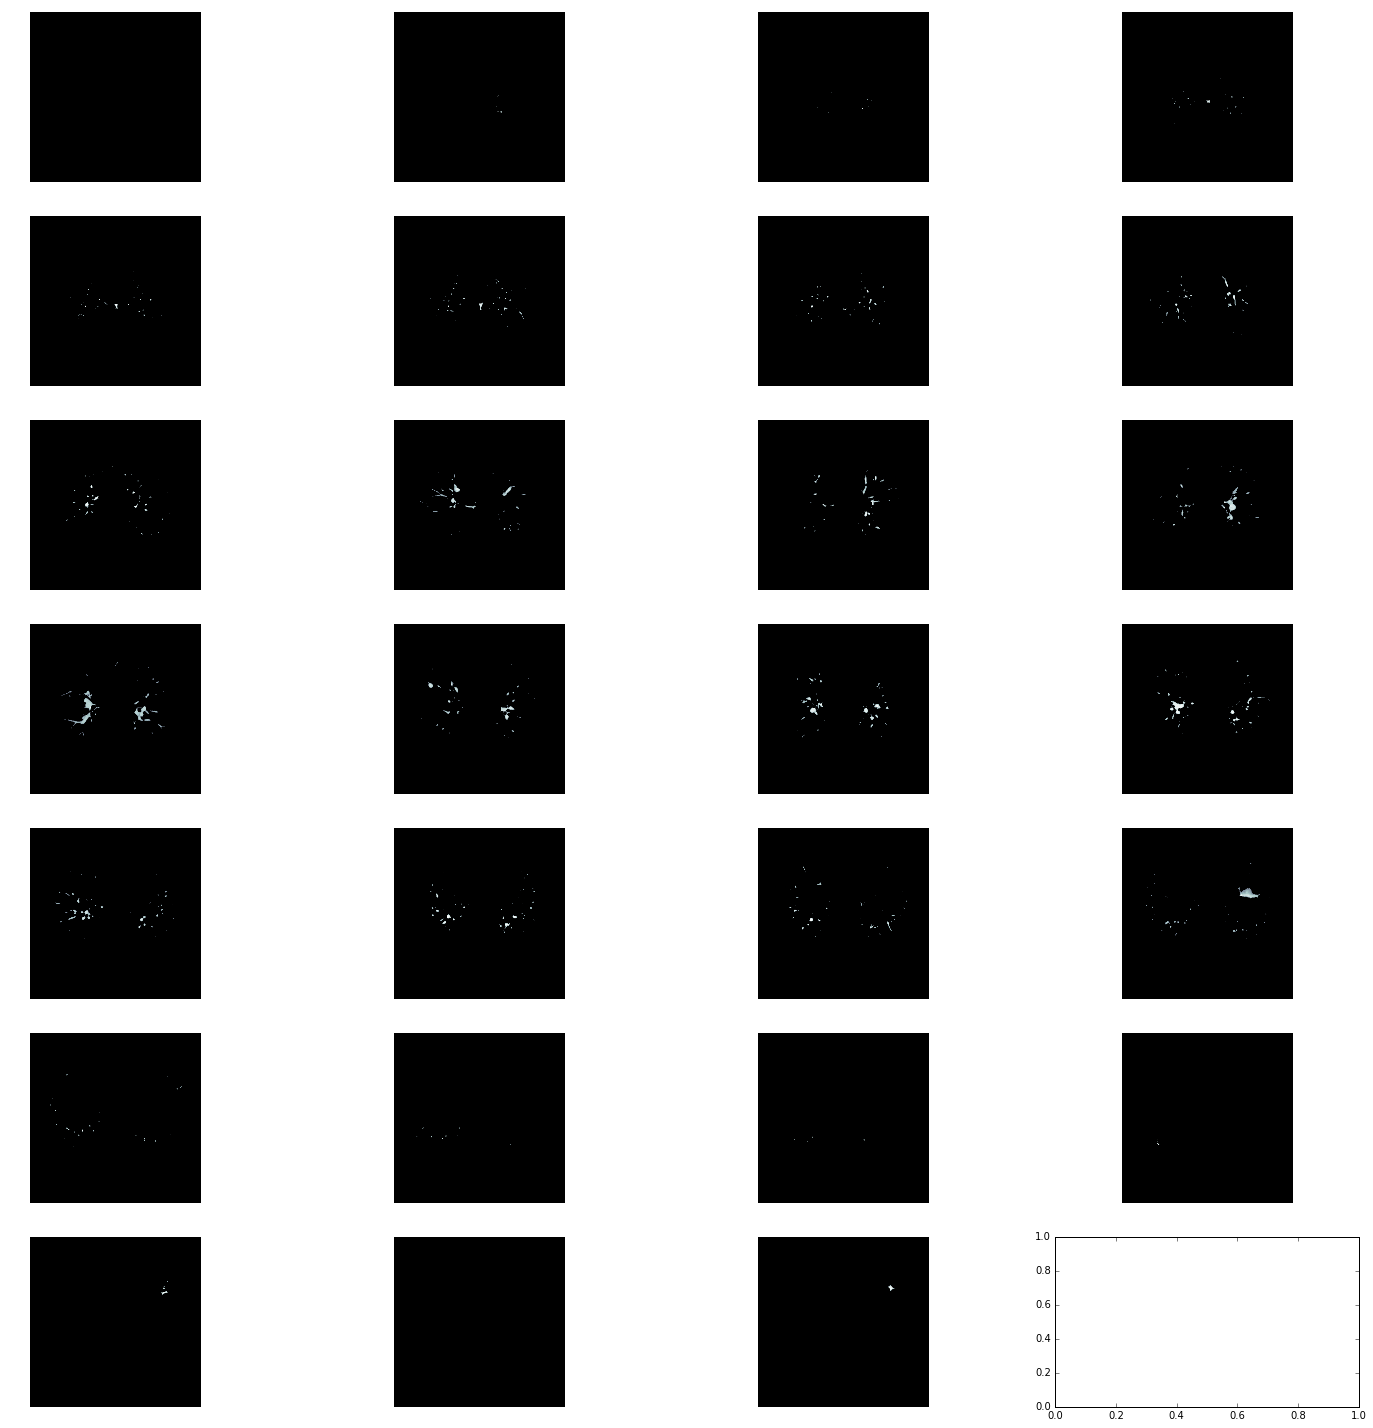

In [12]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

In [13]:
#gidi: i donno what is dis stuff

selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [14]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [15]:

p = segmented_ct_scan.transpose(2,1,0)

In [17]:
segmented_ct_scan.shape

(134, 512, 512)

In [16]:
p = segmented_ct_scan.transpose(2,1,0)
p = p[:,:,::-1]

NameError: name 'threshold' is not defined

In [ ]:
verts, faces = measure.marching_cubes(p, 604)

In [ ]:
mesh = Poly3DCollection(verts[faces], alpha=0.1)

In [ ]:
plot_3d(segmented_ct_scan, 604)

## Luna preprocessing

this section is processing of Luna16 data, and save it as numpy arrays, ready for UNet. problem is, that are only ~100 samples in each ssubset, currenlty only subset 0 is worked (2.3.17)

In [2]:
import SimpleITK as sitk
'''
This funciton reads a '.mhd' file using SimpleITK and return the 
image array, origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [30]:
img, origin, spacing=load_itk(imagePath)

In [31]:
RESIZE_SPACING = [1, 1, 1]
resize_factor = spacing / RESIZE_SPACING
new_real_shape = img.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize = new_shape / img.shape
new_spacing = spacing / real_resize

In [37]:
lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)

In [38]:
lung_img.shape

(280, 340, 340)

In [39]:
lung_img = lung_img + 1024
lung_mask = segment_lung_from_ct_scan(lung_img)
lung_img = lung_img - 1024

In [1]:
lung_img.shape

NameError: name 'lung_img' is not defined

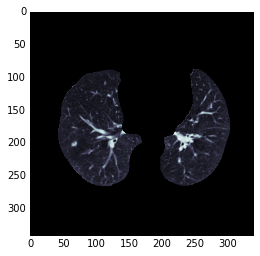

In [73]:
plt.imshow(lung_mask[113], cmap=plt.cm.bone)

In [56]:
nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

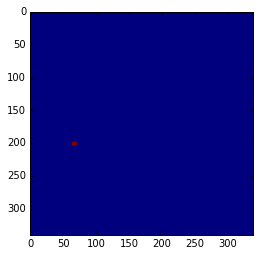

In [72]:
plt.imshow(nodule_mask[113])

In [47]:
image_mask = np.zeros(lung_img.shape)

In [52]:
image_mask[(109,197,63)]

0.0

In [88]:
def seq(start, stop, step=1):
	n = int(round((stop - start)/float(step)))
	if n > 1:
		return([start + step*i for i in range(n+1)])
	else:
		return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
	#make empty matrix, which will be filled with the mask
	RESIZE_SPACING = [1, 1, 1]
	image_mask = np.zeros(image.shape)

	#run over all the nodules in the lungs
	for ca in cands:
		#get middel x-,y-, and z-worldcoordinate of the nodule
		radius = np.ceil(ca[4])/2
		coord_x = ca[1]
		coord_y = ca[2]
		coord_z = ca[3]
		image_coord = np.array((coord_z,coord_y,coord_x))

		#determine voxel coordinate given the worldcoordinate
		image_coord = world_2_voxel(image_coord,origin,spacing)

		#determine the range of the nodule
		noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

		#create the mask
		#print (coord_z)
		for x in noduleRange:
			for y in noduleRange:
				for z in noduleRange:
					coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
					#print (np.round(coords[0]),np.round(coords[1]),np.round(coords[2]))
					if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        
						image_mask[int(np.round(coords[0])),int(np.round(coords[1])),int(np.round(coords[2]))] = int(1)
	
	return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
	#if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
	img, origin, spacing = load_itk(imagePath)

	#calculate resize factor
	RESIZE_SPACING = [1, 1, 1]
	resize_factor = spacing / RESIZE_SPACING
	new_real_shape = img.shape * resize_factor
	new_shape = np.round(new_real_shape)
	real_resize = new_shape / img.shape
	new_spacing = spacing / real_resize
	
	#resize image
	lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
	lung_img = lung_img + 1024
	lung_mask = segment_lung_from_ct_scan(lung_img)
	lung_img = lung_img - 1024

	#create nodule mask
	nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

	lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

	original_shape = lung_img.shape	
	for z in range(lung_img.shape[0]):
		offset = (512 - original_shape[1])
		upper_offset = np.round(offset/2)
		lower_offset = offset - upper_offset

		new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

		lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
		lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
		nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
	np.save(imagePath + '_lung_img.npz', lung_img_512)
	np.save(imagePath + '_lung_mask.npz', lung_mask_512)
	np.save(imagePath + '_nodule_mask.npz', nodule_mask_512)
        

In [86]:
import pandas as pd
annos=pd.read_csv('/datadrive/kaggle_ds_bowl_17/luna16/annotations.csv')

In [81]:
luna_path='/datadrive/kaggle_ds_bowl_17/luna16/subset0/'

In [77]:
% cd /datadrive/kaggle_ds_bowl_17/luna16/subset0/

/datadrive/kaggle_ds_bowl_17/luna16/subset0


In [78]:
import glob
g=glob.glob('*.mhd')

In [90]:
#this may take some time for even one subset... which is around 90 scans
for image_name in g:
    print image_name
    cands=[[row[1][0],row[1][1],row[1][2],row[1][3],row[1][4]] for row in  annos[annos.seriesuid==image_name].iterrows()]
    create_nodule_mask(luna_path+image_name,'',cands)
    

1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
1.3.6.1.4.1.14519.5.2.1.6279.6001.

In [4]:
path='/datadrive/kaggle_ds_bowl_17/luna16/'

## read and preprcocess ds17 data

In [ ]:
#get to the fodler V
#read all images to file list V
#read all scans V
# do something with them... average? V
#more preprocessing?
# predict with vgg

In [18]:
% cd /datadrive/kaggle_ds_bowl_17/stage1/

/datadrive/kaggle_ds_bowl_17/stage1


In [24]:
import glob
ds_files=glob.glob('*/*.dcm')

In [30]:
folders=[file.split('/')[0] for file in ds_files]
unique_folders=np.unique(folders)

In [31]:
len(unique_folders)

1595

In [55]:
% cd ../stage1_segmented/

/datadrive/kaggle_ds_bowl_17/stage1_segmented


In [56]:
current=glob.glob('*.npy')

In [59]:
current=[item.split('.')[0] for item in current]

In [60]:
current

['5f383eb9c3d8ea72ddec7e2e874d577d',
 '502e157e6a22166997d054e8920d921c',
 '01de8323fa065a8963533c4a86f2f6c1',
 'b8793dbd40de88c0de0913abbaab0fe7',
 '5791c42d317f34592be9a933c50e68ad',
 'a590753c175011e42bf17b90e3aec3b0',
 'e314fd13809db0132443b924401d828b',
 '6d60c26d7d35ffd967127b380ff01c12',
 'c67e799bcc1e2635eb9164f6e8cf75f3',
 '96544665531e7f59bc2730e3c5f42e65',
 '529e4dd38822b413a4a87e6f4faa5f23',
 'af2b9f7d489ffab8e3590658853cacf8',
 '7fb1c8ffd78ca4b6869044251add36b4',
 '2b861ff187c8ff2977d988f3d8b08d87',
 '2d596b6ead89ab35577fe625a9a17cbb',
 '721949894f5309ed4975a67419230a3c',
 'df8614fd49a196123c5b88584dd5dd65',
 'ad7e6fe9d036ed070df718f95b212a10',
 '72a1e35c34052e163f61585ba0c9daf4',
 '5bb9185543527cd034aa48fc0b623874',
 '775c5f8043e72b2284b5885254566271',
 '0eafe9b9182b80c6d67015a2062f5143',
 '624a34fa8fd36847724e749877343847',
 '54056288ab97cebc4b0ea33c23f47ff6',
 'cd104ad99d5b939b6bdd28b154e28085',
 '6629e23c3bdc8dc8161b3caa8a6048c1',
 'a34714908825a61a229bf1457c21ff1f',
 

folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder skipped
folder ski

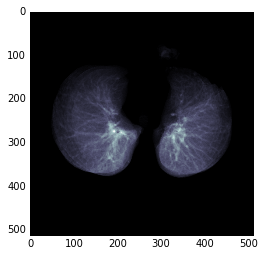

In [61]:
#segmentation and saving of ds 17. 
#expected to take 27X1500=40,000 seconds. 10 hours,  all night :)
scan_list=[]
path='/datadrive/kaggle_ds_bowl_17/stage1/'
for folder in unique_folders:
    t=time.time()
    if folder not in current:
        ct_scan = read_ct_scan(path+folder+'/') 
        segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
        plt.imshow(np.mean(segmented_ct_scan,axis=0), cmap=plt.cm.bone)
        print 'segmentation took ',time.time()-t
        t=time.time()
        np.save('/datadrive/kaggle_ds_bowl_17/stage1_segmented/'+folder + '.npy', segmented_ct_scan)

        print folder,'saved, took ',time.time()-t
    else:
        print 'folder skipped'

In [41]:
a=np.load('/datadrive/kaggle_ds_bowl_17/stage1_segmented/0015ceb851d7251b8f399e39779d1e7d.npy')

In [42]:
a.shape

(195, 512, 512)

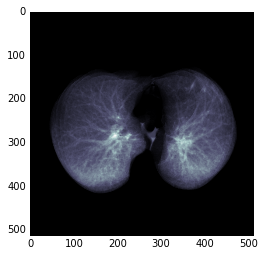

In [50]:
plt.imshow(np.mean(a,axis=0), cmap=plt.cm.bone)